# PAGA

Running PAGA for pseudotime + trajectories. Python 3 (singlecell env).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from matplotlib import rcParams
import scanpy as sc
from collections import Counter

In [63]:
import sys
sys.version

'3.6.7 | packaged by conda-forge | (default, Nov  6 2019, 16:19:42) \n[GCC 7.3.0]'

In [66]:
pd.__version__

'0.25.3'

In [6]:
sc.__version__

'1.4.4.post1'

### Cluster Config

In [2]:
cluster_config = pd.read_csv("../../figures_factory/configs/cluster.tsv", sep='\t')
cluster_config

,cluster,colour,description,new_cluster
0,1,#B03743,Fibroblast,1
1,2,#E85F6D,Fibroblast-like,3
2,3,#7C2730,Fibroblast-like,2
3,4,#F0A118,Intermediate,12
4,5,#78A824,Pre-iPSC,13
5,6,#A6D854,Pre-iPSC,14
6,7,#F01D35,Fibroblast-like,5
7,8,#13C4A3,iPSC,15
8,9,#406614,Partially-reprogrammed,10
9,10,#D4B81C,Intermediate,9


## Data

In [3]:
features = pd.read_csv("../20200206_pmat_snapATAC/sessions/20210717_n62599/features.10d.tsv", sep='\t')
features.head()

,sample_barcode,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10
0,D0_AAACACGCTAGTACGG,-0.011152,0.004344,0.000253,0.008402,0.008648,0.010894,-0.009443,0.007333,-0.001019,0.004180
1,D0_AAACACGCTCTTCAAG,-0.009688,0.003813,-0.001958,0.002900,0.006727,0.021008,-0.000742,0.004307,0.000922,0.002110
2,D0_AAACACGCTGATCCAT,-0.010975,0.003616,0.000350,0.004525,0.001076,0.001667,-0.009498,0.004310,-0.005080,0.004723
3,D0_AAACCCTGACCGCTAG,-0.014855,0.004357,0.003624,0.007491,-0.000067,0.003828,-0.013560,0.006658,0.001154,0.009558
4,D0_AAACCCTGATTGCAGT,-0.012246,0.004827,0.001439,0.005282,0.008118,0.015957,-0.000762,-0.004423,0.002829,0.004031


In [4]:
metaData = pd.read_csv("../20200206_pmat_snapATAC/sessions/20210717_n62599//metadata.tsv", sep='\t')
metaData.head()

,barcode,sample,umap1,umap2,cluster
0,AAACACGCTAGTACGG,D0,-1.803792,-9.507773,1
1,AAACACGCTCTTCAAG,D0,0.707455,-9.406457,1
2,AAACACGCTGATCCAT,D0,-2.955993,-7.641148,1
3,AAACCCTGACCGCTAG,D0,-3.611911,-8.443144,1
4,AAACCCTGATTGCAGT,D0,0.500212,-8.759449,3


In [7]:
adata = sc.AnnData(shape=(features.shape[0], 10))
adata

AnnData object with n_obs × n_vars = 62599 × 10 

In [8]:
# feature representation
adata.obsm['X_diff'] = np.array(features.iloc[:, 1:])

# temporarily set X to X_diff also (downstream stuff doesn't work otherwise)
adata.X = adata.obsm['X_diff']

In [9]:
# use precomputed umap for consistency
adata.obsm['X_umap'] = np.array(metaData[["umap1", "umap2"]])

In [10]:
# new cluster labels
adata.obs["new_cluster"] = [str(x) for x in cluster_config.iloc[metaData['cluster']-1]["new_cluster"]]

In [11]:
adata

AnnData object with n_obs × n_vars = 62599 × 10 
    obs: 'new_cluster'
    obsm: 'X_diff', 'X_umap'

In [12]:
# TEMP (Remove potential doublet cell states)
# adata = adata[~adata.obs['new_cluster'].isin(['10', '17', '18'])]

In [13]:
# set back adata.X to None
# adata.X = None  # Doesn't work

... storing 'new_cluster' as categorical


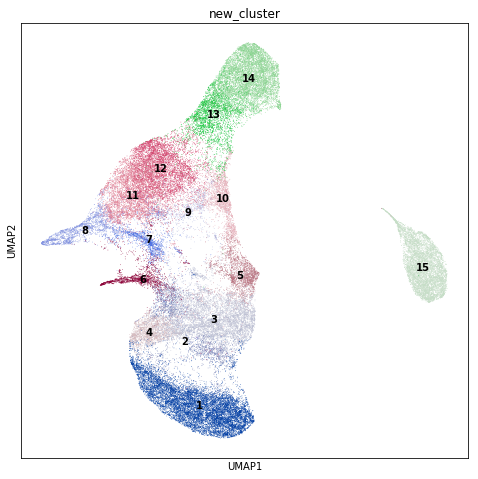

In [14]:
rcParams['figure.figsize'] = 8, 8

sc.pl.umap(adata, color="new_cluster", legend_loc='on data')

## Trajectory

In [15]:
sc.pp.neighbors(adata, n_neighbors=15, use_rep='X_diff')

/users/surag/anaconda3/envs/singlecell/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../anaconda3/envs/singlecell/lib/python3.6/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/users/surag/anaconda3/envs/singlecell/lib/python3.6/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../..

In [16]:
sc.tl.paga(adata, groups='new_cluster')

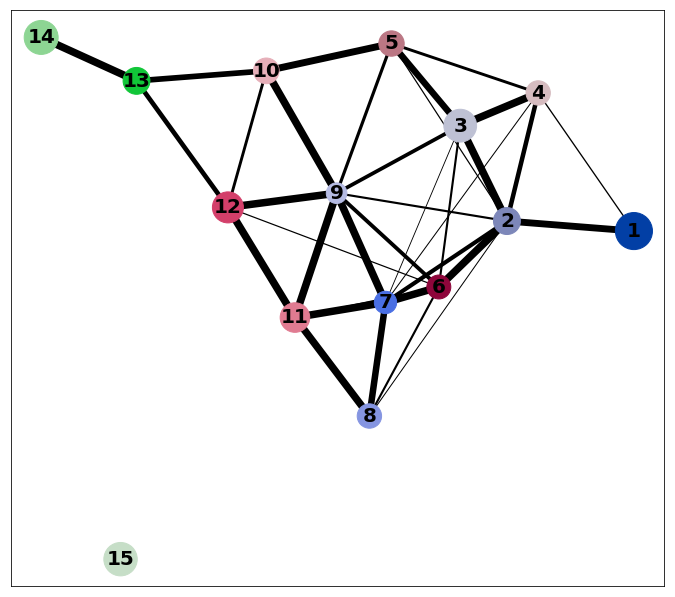

In [17]:
rcParams['figure.figsize'] = 10, 10

sc.pl.paga(adata, 
           threshold=.1, 
           fontsize=20, 
           node_size_scale=5,
#            solid_edges='connectivities_tree',
           show=True)

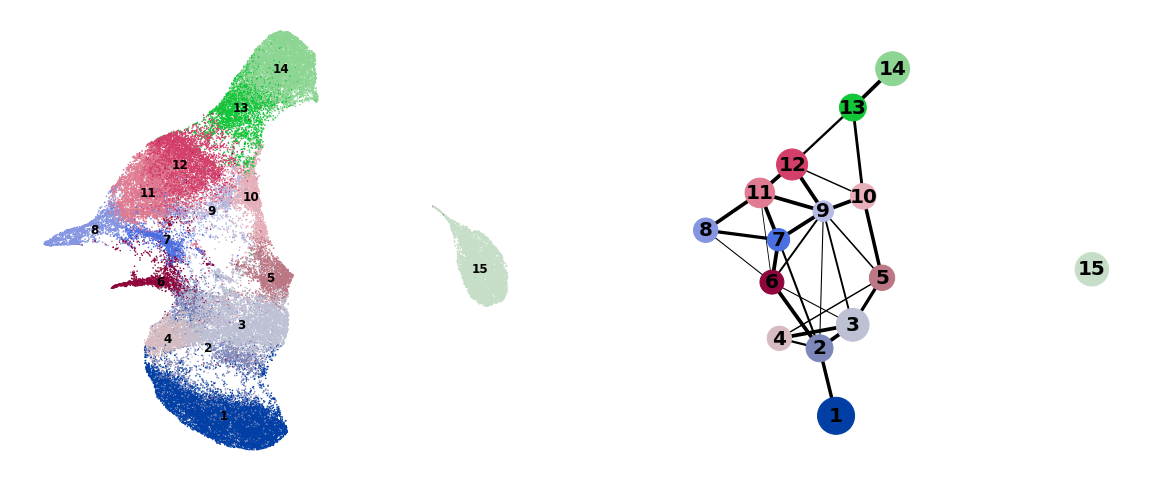

In [62]:
sc.pl.paga_compare(
    adata, threshold=0.2, title='', right_margin=0.2, size=10, edge_width_scale=0.5,
    legend_fontsize=12, frameon=False, edges=False, save=True,
    fontsize=20, 
    node_size_scale=5)

### Pseudotime

### Starting with Fibroblast cell

In [51]:

adata.uns['iroot'] = np.flatnonzero(adata.obs['new_cluster']  == '1')[0]
adata.uns['iroot']

0

In [47]:
# re-running diffmaps though these features are diffmap outputs
# is required for dpt
sc.tl.diffmap(adata)

# can also set X_diffmap equal to X_diff
# but pseudotime is worse
# adata.obsm['X_diffmap'] = adata.obsm['X_diff']

In [48]:
sc.tl.dpt(adata)

# if using X_diff
# sc.tl.dpt(adata, n_dcs=9)

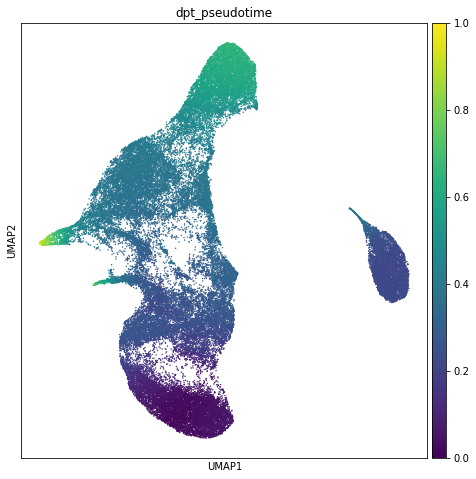

In [49]:
rcParams['figure.figsize'] = 8, 8

sc.pl.umap(adata, color=['dpt_pseudotime'], 
           size=8, 
           legend_loc='on data')

In [55]:
fibr_pseudotime = list(adata.obs['dpt_pseudotime'].copy())

### Starting with high OSK cell

In [52]:
np.argmin(adata.obsm['X_umap'][:,0])

30191

In [56]:
# left-most high OSK cell
adata.uns['iroot'] = np.argmin(adata.obsm['X_umap'][:,0]) 

In [57]:
sc.tl.diffmap(adata)
sc.tl.dpt(adata)

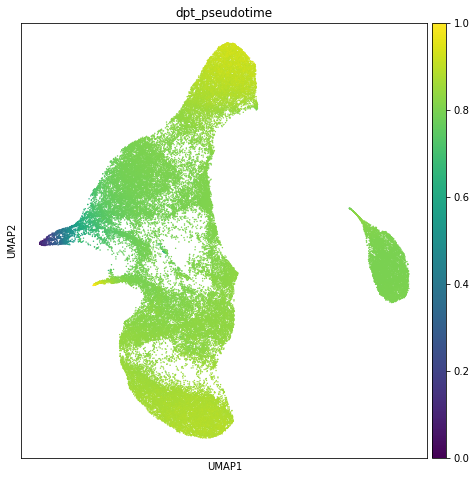

In [58]:
rcParams['figure.figsize'] = 8, 8

sc.pl.umap(adata, color=['dpt_pseudotime'], 
           size=8, 
           legend_loc='on data')

In [59]:
high_OSK_pseudotime = list(adata.obs['dpt_pseudotime'].copy())

## Write Session Outputs

Currently unused.

In [25]:
SESH_NAME = "20211003_n{}".format(adata.shape[0])
SESH_NAME

'20211003_n62599'

In [27]:
# write PAGA connectivities matrix
conn = pd.DataFrame(adata.uns['paga']['connectivities'].todense(), 
                    index=[f'c{x}' for x in adata.obs['new_cluster'].dtype.categories],
                    columns=[f'c{x}' for x in adata.obs['new_cluster'].dtype.categories])
conn

,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15
c1,0.000000,0.913845,0.078249,0.176025,0.003156,0.004401,0.003044,0.012163,0.000758,0.000000,0.000000,0.000186,0.000000,0.000000,0.000000
c2,0.913845,0.000000,1.000000,0.602285,0.163488,1.000000,0.554621,0.134894,0.285168,0.000567,0.019396,0.002919,0.001887,0.000093,0.000000
c3,0.078249,1.000000,0.000000,1.000000,0.858375,0.284723,0.117376,0.050839,0.500529,0.020786,0.057757,0.004623,0.003136,0.000763,0.000271
c4,0.176025,0.602285,1.000000,0.000000,0.388383,0.046861,0.136415,0.002097,0.035752,0.001282,0.013054,0.001001,0.000000,0.000000,0.000000
c5,0.003156,0.163488,0.858375,0.388383,0.000000,0.034425,0.027776,0.015984,0.420407,0.926549,0.015968,0.008474,0.056037,0.013469,0.000000
c6,0.004401,1.000000,0.284723,0.046861,0.034425,0.000000,1.000000,0.283480,0.514104,0.022835,0.225507,0.161878,0.038015,0.006112,0.006183
c7,0.003044,0.554621,0.117376,0.136415,0.027776,1.000000,0.000000,0.868388,1.000000,0.036781,1.000000,0.098253,0.010540,0.000197,0.001465
c8,0.012163,0.134894,0.050839,0.002097,0.015984,0.283480,0.868388,0.000000,0.021285,0.000000,0.973634,0.007943,0.003177,0.000277,0.002061
c9,0.000758,0.285168,0.500529,0.035752,0.420407,0.514104,1.000000,0.021285,0.000000,1.000000,1.000000,1.000000,0.072217,0.004855,0.000287
c10,0.000000,0.000567,0.020786,0.001282,0.926549,0.022835,0.036781,0.000000,1.000000,0.000000,0.043800,0.385098,0.755107,0.033405,0.002280


In [28]:
(conn>0.2).sum().sum()

58

In [30]:
conn.to_csv(f"./sessions/{SESH_NAME}/connectivities.tsv", sep='\t')

In [60]:
# write umap coordinates, pseudotime, sample, cluster for downstream analysis
metadata = pd.DataFrame({'sample_barcode':list(features["sample_barcode"]), 
                         'dpt_pseudotime_fibr':fibr_pseudotime,
                        'dpt_pseudotime_high_OSK': high_OSK_pseudotime})
metadata.head()

,sample_barcode,dpt_pseudotime_fibr,dpt_pseudotime_high_OSK
0,D0_AAACACGCTAGTACGG,0.000000,0.874737
1,D0_AAACACGCTCTTCAAG,0.038849,0.878233
2,D0_AAACACGCTGATCCAT,0.101714,0.846661
3,D0_AAACCCTGACCGCTAG,0.092293,0.849594
4,D0_AAACCCTGATTGCAGT,0.050279,0.862673


In [61]:
metadata.to_csv("./sessions/{}/pseudotime.tsv".format(SESH_NAME), sep='\t')

In [ ]:
sc.pl.paga(adata, color=['leiden'], edge_width_scale=0.2, threshold=0.2, show=False)
pl.savefig("./sessions/{}/paga.pdf".format(SESH_NAME))